# INF554 Kaggle challenge notebook
Team: Kagglers

Members: Marian Huot, Antoine Gleisberg, Aude Bouillé

To DO: 
- feature selection with rfe: execute rfe for the rf: identify top number of features,  get the names of these features (see sell after rfe), and then use these features in the rf
- LASSO: identify precisely top alpha and features coeffs (report alpha in report)
- KNN: run cell and identify best number of neighbors (report k in report)
- Using features identified previously, identify top parameters for rf and elastic net
- Part 4 Best models, exectute with best featuers and best parameters; report mae in the report

## Part 0 : general imports and data reading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple

import seaborn as sns

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from verstack.stratified_continuous_split import scsplit

In [3]:
# Load the training data
train_data = pd.read_csv("data/train.csv")

# Load the evaluation data
eval_data = pd.read_csv("data/evaluation.csv")

## Part 1 : data visualisation and feature plotting

In [4]:
def visualize_retweets(n_max, n_min=-1, k=False, b=30):
    y = train_data['retweets_count']
    sns.displot(y[y < n_max][n_min < y], kde=k, bins=b)

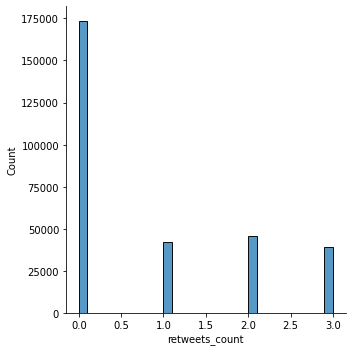

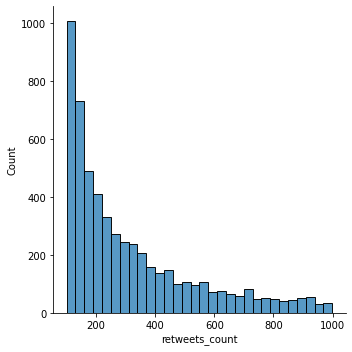

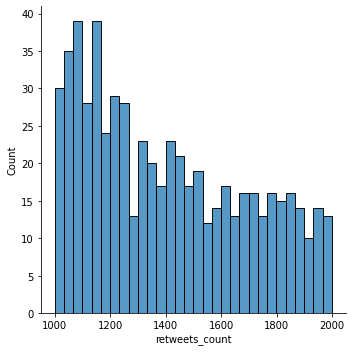

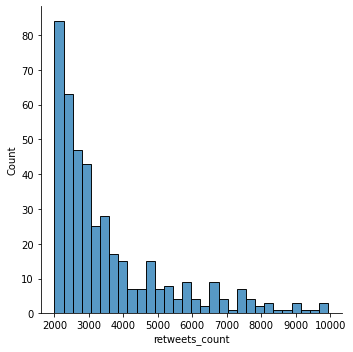

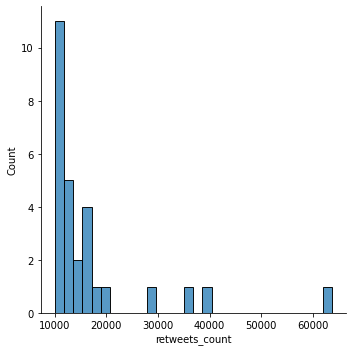

In [35]:
visualize_retweets(4)
visualize_retweets(1000, 100)
visualize_retweets(2000, 1000)
visualize_retweets(10000, 2000)
visualize_retweets(70000, 10000)

## Part 2 : Outlier removal and feature selection

### Part 2.1 : Removal of outliers

This wasn't used in the end because it made results worse than without it.

In [36]:
# remove outliers with quartile
def remove_outliers(df: pd.DataFrame, col: str) -> pd.DataFrame:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[col] >= q1 - 5 * iqr) & (df[col] <= q3 + 5 * iqr)]
    return df

# remove outliers with given percentage p
def remove_outliers_percentage(df, col, p):
    q = df[col].quantile(1 - p / 100)
    df = df[df[col] < q]
    return df

# remove outliers with retweets_count above n
def remove_outliers_above(df, col, n):
    df = df[df[col] < n]
    return df

def percentage_outliers_above(df, col, n):
    z = df[col].copy()
    z[z < n] = 0
    print(f"n = {n} ; Percentage of outliers : {round(len(z[z > 0]) / len(z) * 100, 4)}%")

In [37]:
percentage_outliers_above(train_data, 'retweets_count', 7000)

n = 7000 ; Percentage of outliers : 0.0155%


### Part 2.2 : Train - Test split

In [5]:
# split data using stratified continuous split
X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.8, test_size=0.2)

# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweets_count'], axis=1)
X_test = X_test.drop(['retweets_count'], axis=1)


# split data using sklearn
# X = train_data.drop('retweets_count',axis=1)
# y = train_data['retweets_count']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Part 2.3 : Adding new features

See file utils.py for the functions used to create the new features.

### Part 2.4 : Feature selection

In [6]:
columns = ['TweetID', 'mention', 'urls', 'timestamp', 'text', 'total_text', 'hashtags', 'followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'verified', 'url_count', 'followers_friends',
       'hour', 'day','week_in_month', 'polarity', 'subjectivity', 'hashtags_count', 'topic_1','topic_2', 'topic_3','topic_4', 'topic_5','cluster']

useless_cols = ["TweetID", "mention", "urls", "timestamp", "text", "hashtags", "total_text"]

In [7]:
from utils import clean_data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
new_train_data = clean_data(X_train, columns, useless_cols)
new_test_data = clean_data(X_test, columns, useless_cols)

This section was used for testing purposes : trying to remove different features for the best possible results

In [9]:
unimportant_cols = []

In [10]:
new_train_data = new_train_data.drop(unimportant_cols, axis=1)
new_test_data = new_test_data.drop(unimportant_cols, axis=1)

In [11]:
new_train_data.head()

,followers_count,friends_count,favorites_count,statuses_count,verified,url_count,followers_friends,hour,day,week_in_month,polarity,subjectivity,hashtags_count,topic_1,topic_2,topic_3,topic_4,topic_5,cluster
162587,10031,1288,98,51530,0,0,7.782002,21,0,2,0.0000,0.000,0,0.000177,0.000090,-0.000017,0.000259,-0.000012,52
172041,13,64,0,196,0,1,0.200000,16,6,1,-0.0125,0.125,0,0.038548,-0.001453,-0.009187,0.081172,0.008989,74
259551,4307,3887,0,97278,0,1,1.107767,13,3,2,0.0000,0.000,0,0.135939,0.108164,-0.050425,0.044753,0.087634,45
273568,174,3147,0,730,0,0,0.055273,8,2,1,0.0000,0.000,1,0.006264,-0.000222,0.000238,0.001927,0.001106,74
334651,5249,4145,8,21794,0,1,1.266040,10,2,2,0.0000,0.000,2,0.026648,-0.010884,-0.002087,-0.002381,0.004962,69


## Part 3 : Model selection

## Pipeline to get a first overview befopre optimizing

Importing different regressors

In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [13]:
pipelines: List[Tuple[str, bool, Tuple[float, float], Pipeline]] = []
# Add some general models
pipelines.append(('ScaledKNN',      False, (0, 0), Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor(5))])))
pipelines.append(('ScaledLR',       False, (0, 0), Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())] )))
# pipelines.append(('ScaledGBM',      False, (0, 0), Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
# pipelines.append(('UnscaledGBM',    False, (0, 0), Pipeline([('GBM', GradientBoostingRegressor())])))
# pipelines.append(('ScaledCART',     False, (0, 0), Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeRegressor())])))
# pipelines.append(('UnscaledCART',  False, (0, 0), Pipeline([('CART', DecisionTreeRegressor())])))
# pipelines.append(('ScaledRF',       False, (0, 0), Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))])))
# pipelines.append(('UnscaledRF',     False, (0, 0), Pipeline([('RF', RandomForestRegressor(n_estimators=10))])))

# Add the optimised models
# pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
# pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
# pipelines.append(('OptimizedRF', Pipeline([('RF', RandomForestRegressor(max_features=0.93, max_leaf_nodes=2310, n_estimators=90, n_jobs=-1))])))
# pipelines.append(('OptimizedXGB', Pipeline([('XGB', XGBRegressor(base_score=0.5, booster='gbtree'))])))


In [14]:
recalculate_models = False

if recalculate_models:
    for i, (name, was_evaluated, (mean, std), model) in enumerate(pipelines):
        if not was_evaluated:
            kfold = KFold(n_splits=10)
            cv_results = cross_val_score(model, new_train_data, y_train, cv=kfold, scoring='neg_mean_absolute_error')
            pipelines[i] = (name, True, (cv_results.mean(), cv_results.std()), model)
        print(f"{name}: {pipelines[i][2][0]} ({pipelines[i][2][1]})")


Min Max Scaler
- ScaledKNN: -19.18159363427886 (1.5453010098400695)
- ScaledLR: -11.161187928446045 (0.9388509996875113)

Standard Scaler
- ScaledKNN: -10.626873889833448 (0.7770515292830723)
- ScaledLR: -11.161187928446022 (0.9388509996874855)


#we choose the standard scaler for knn and lr which depends on value distribution


In [15]:
# cross validation already gives us MAE of each model
if False:
   for name, was_evaluated, (mean, std), model in pipelines:
      model.fit(new_train_data, y_train)
      predictions = model.predict(new_test_data)
      predictions = [round(value) if value >= 0 else 0 for value in predictions]
      print(f"{name} done.\nMean absolute error: {mean_absolute_error(y_test, predictions)}")

Copy of the output :

ScaledLR done.
Mean absolute error: 9.881812017967624

ScaledLASSO done.
Mean absolute error: 10.339110659095404

ScaledEN done.
Mean absolute error: 14.335480407944177

ScaledKNN done.
Mean absolute error: 10.022233522614911

ScaledCART done.
Mean absolute error: 9.562943187275758

ScaledGBM done.
Mean absolute error: 6.972751928129503

ScaledRF done.
Mean absolute error: 7.212447382546544

OptimizedRF done.
Mean absolute error: 6.73951182303585

OptimizedXGB done.
Mean absolute error: 6.812173348023844


### Feature selection plot with RFE

### Scaler

In [16]:
#Use a minmax scaler to scale the data

scaler = StandardScaler()
scaler.fit(new_train_data)
scaled_train_data = scaler.transform(new_train_data)
scaled_test_data = scaler.transform(new_test_data)# used for Lasso and KNN

In [17]:
lr=LinearRegression()
rf=RandomForestRegressor(n_estimators=10)

#Plot mae for each model with rfe
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def plot_mae(model, X, y, plot_title, figsize=(10,15), range_features_to_select=None):
    if range_features_to_select is None:
        range_features_to_select = (1, X.shape[1]+1)
    mae = []
    for i in range(*range_features_to_select):
        rfe = RFE(model,n_features_to_select=i)
        X_rfe = rfe.fit_transform(X, y)
        mae.append(np.mean(cross_val_score(model, X_rfe, y, scoring='neg_mean_absolute_error')))
    plt.figure(figsize=figsize)
    plt.grid(visible=True)
    plt.xticks(range(*range_features_to_select))
    plt.plot(range(*range_features_to_select), mae)#use new_train_data.columns because X has been scaled and therefore has no more column names
    plt.title(plot_title)
    plt.xlabel('Number of features')
    plt.ylabel('MAE')
    plt.show()

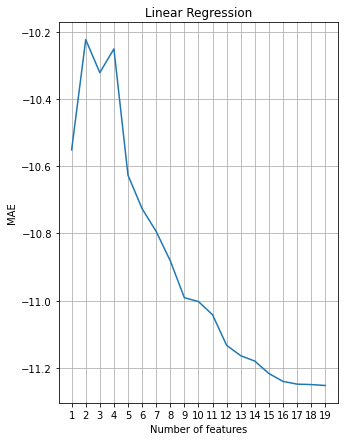

In [129]:
plot_mae(lr, scaled_train_data, y_train, plot_title='Linear Regression', figsize=(5,7)) # prendre figsize = (10, 15) pour le rapport

In [101]:
# Takes about 10 minutes per point in the range of features
# plot_mae(rf, new_train_data, y_train, plot_title='Random Forest', range_features_to_select=(1,len(new_train_data.columns)))

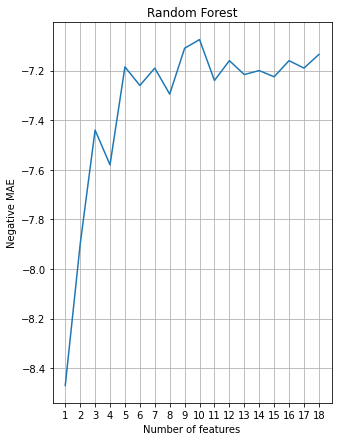

In [127]:
# Writing down the results of the RFE for RF because it takes a long time to run
# PLEASE DONT DELETE THIS CELL
# 6 hours of execution time

nb_of_features = [1,        2,      3,      4,      5,      6,      7,      8,  9,      10,     11,     12,     13,   14,   15,     16,     17,     18]
mae =            [-8.47,    -7.9,   -7.44, -7.58, -7.185, -7.26, -7.19, -7.295, -7.11, -7.075, -7.24, -7.16, -7.216, -7.2, -7.225, -7.16, -7.19, -7.135]
plt.figure(figsize=(5, 7))
plt.grid(visible=True)
plt.xticks(nb_of_features)
plt.plot(nb_of_features, mae)
plt.title('Random Forest')
plt.xlabel('Number of features')
plt.ylabel('Negative MAE')
plt.show()

In [102]:
#Next step after plot: identify ideal nb of features and get the name of these features
#Then use these features in the model

# LR gave best results with 3 features
RFE_LR = RFE(lr, n_features_to_select=3)
X_rfe_lr = RFE_LR.fit_transform(scaled_train_data, y_train)
mask1 = RFE_LR.support_
#show the features that are selected
print("The best features for LR are:")
print(new_train_data.columns[mask1])

# RF gave best results with 10 features
RFE_RF = RFE(rf, n_features_to_select=10)
X_rfe_rf = RFE_RF.fit_transform(new_train_data, y_train)
mask2 = RFE_RF.support_
#show the features that are selected
print("The best features for RF are:")
print(new_train_data.columns[mask2])



The best features for LR are:
Index(['friends_count', 'favorites_count', 'verified'], dtype='object')
The best features for RF are:
Index(['followers_count', 'friends_count', 'favorites_count', 'statuses_count',
       'followers_friends', 'hour', 'topic_2', 'topic_3', 'topic_4',
       'topic_5'],
      dtype='object')


Best LR features : friends_count, favorites_count, verified

Best RF features : followers_count, friends_count, favorites_count, statuses_count, followers_friends, hour, topic_2, topic_3, topic_4, topic_5

### Hyper paramter tuning to avoid overfitting

Use identified features for each of these three models

## Lasso

In [18]:
scaler = StandardScaler()
train_lasso = new_train_data[['followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'followers_friends', 'hour', 'topic_2', 'topic_3', 'topic_4', 'topic_5']]
test_lasso = new_test_data[['followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'followers_friends', 'hour', 'topic_2', 'topic_3', 'topic_4', 'topic_5']]
scaler.fit(train_lasso)
scaled_train_lasso = scaler.transform(train_lasso)
scaled_test_lasso = scaler.transform(test_lasso)

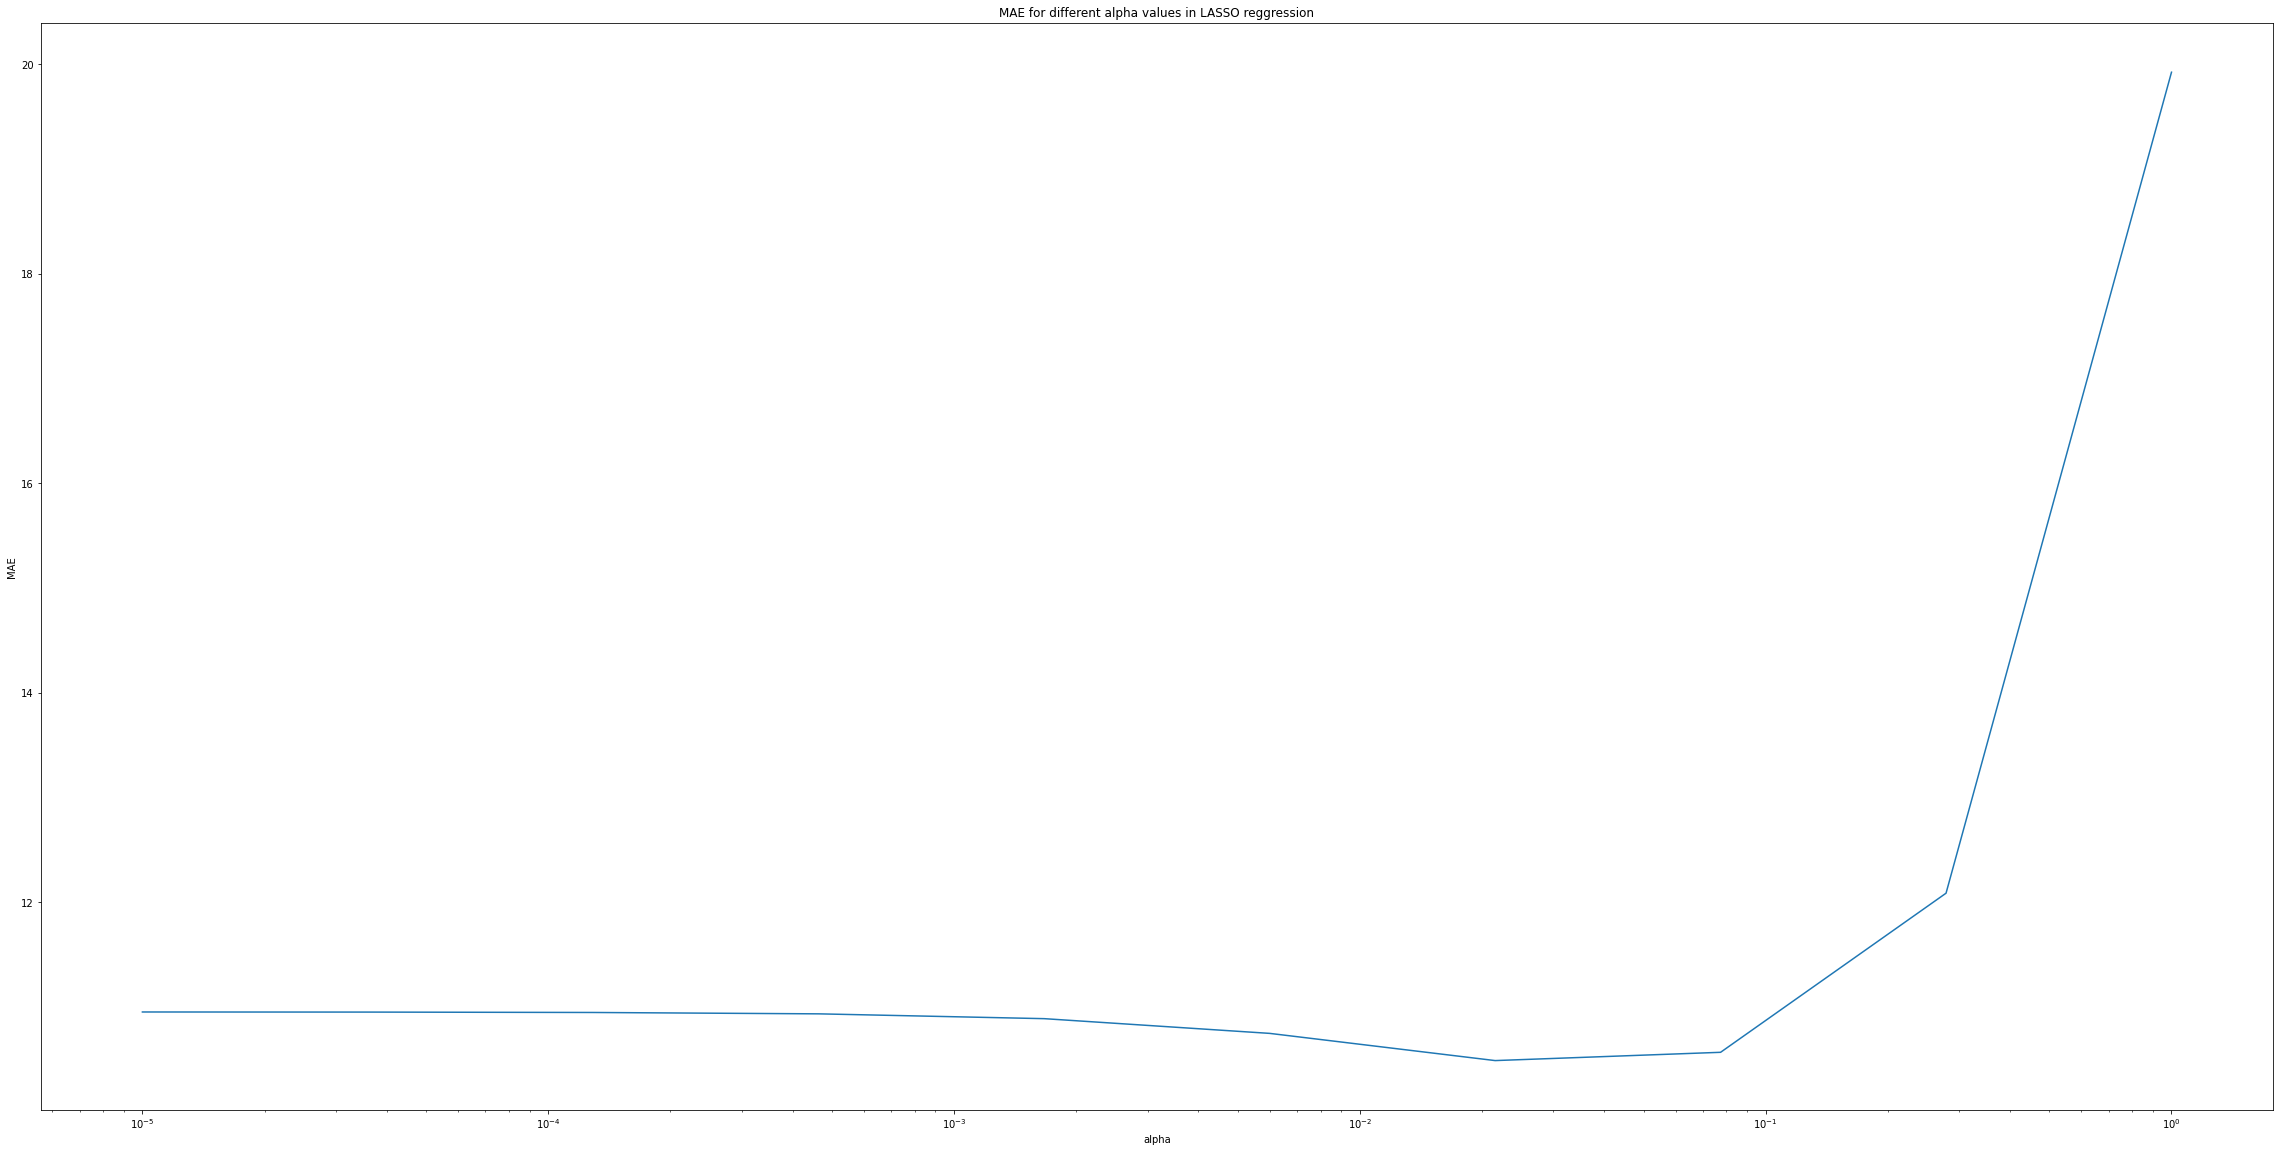

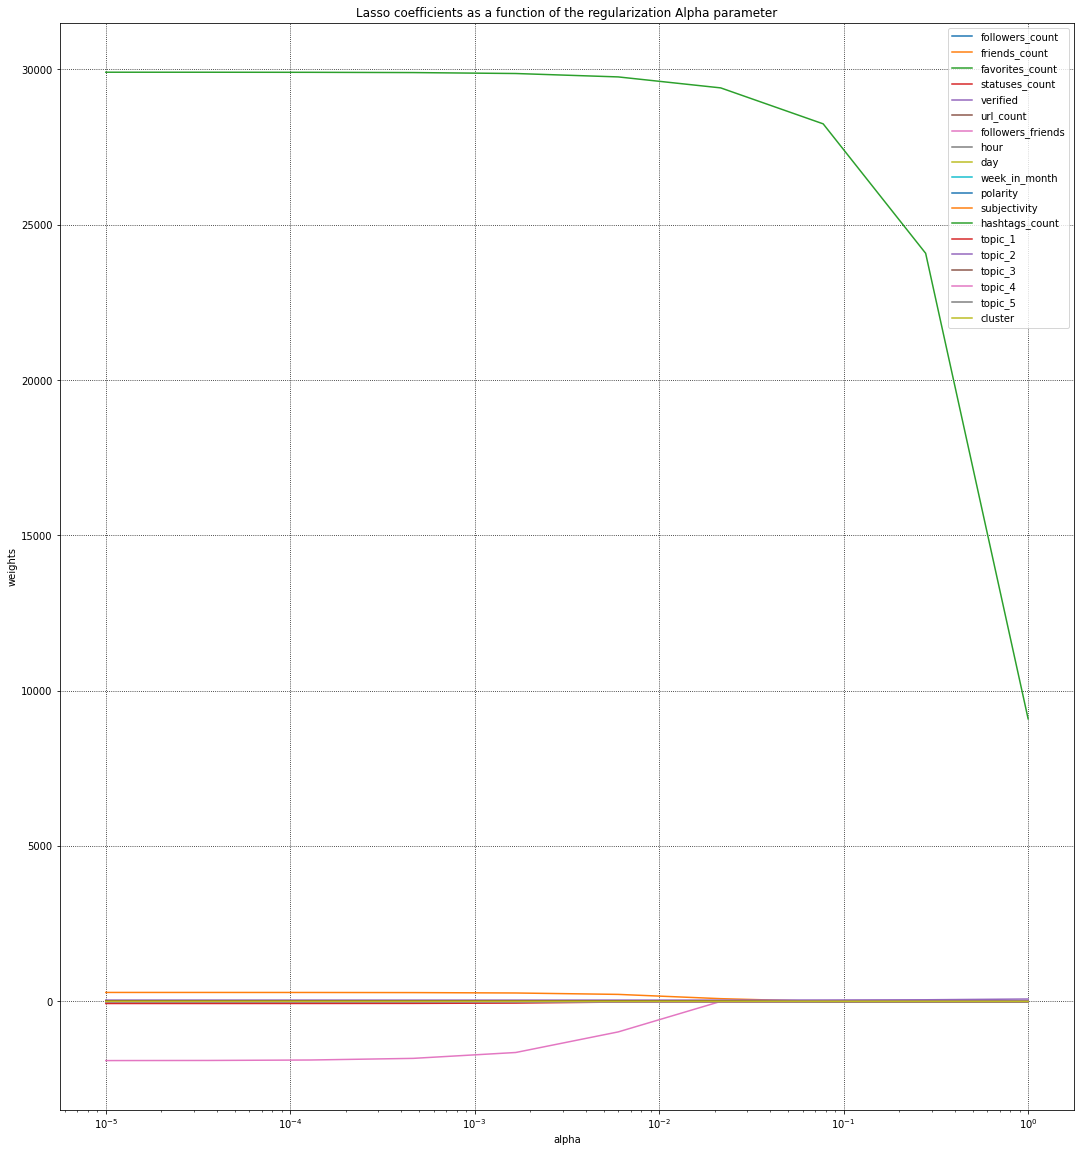

In [ ]:
# Now we can train our model.  we set our loss function 
from sklearn.linear_model import Lasso

#plot linear regression result with LASSO regularization with alpha between 0 and 1
alpha = np.logspace(-5, 0, 10)
mae = []
coefs = []
for a in alpha:
    reg = Lasso(alpha=a)
    reg.fit(scaled_train_lasso,y_train )
    pred = reg.predict(scaled_test_lasso)
    mae.append(mean_absolute_error(pred, y_test))
    coefs.append(reg.coef_)

#size of the plot
plt.figure(figsize=(40, 20))
ax = plt.gca()
ax.plot(alpha, mae)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title("MAE for different alpha values in LASSO reggression")

plt.show()

#plot lasso coefficients for different alpha values
plt.figure(figsize=(40, 20))
plt.subplot(121)
ax = plt.gca()
ax.plot(alpha, coefs)
ax.legend(new_train_data.columns)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization Alpha parameter')
plt.axis('tight')
plt.grid(color='black', linestyle='dotted')
plt.show()

## KNN

4
5
6
7
8
9
10
11
12
13


Text(0.5, 1.0, 'MAE for different K values in KNN regression')

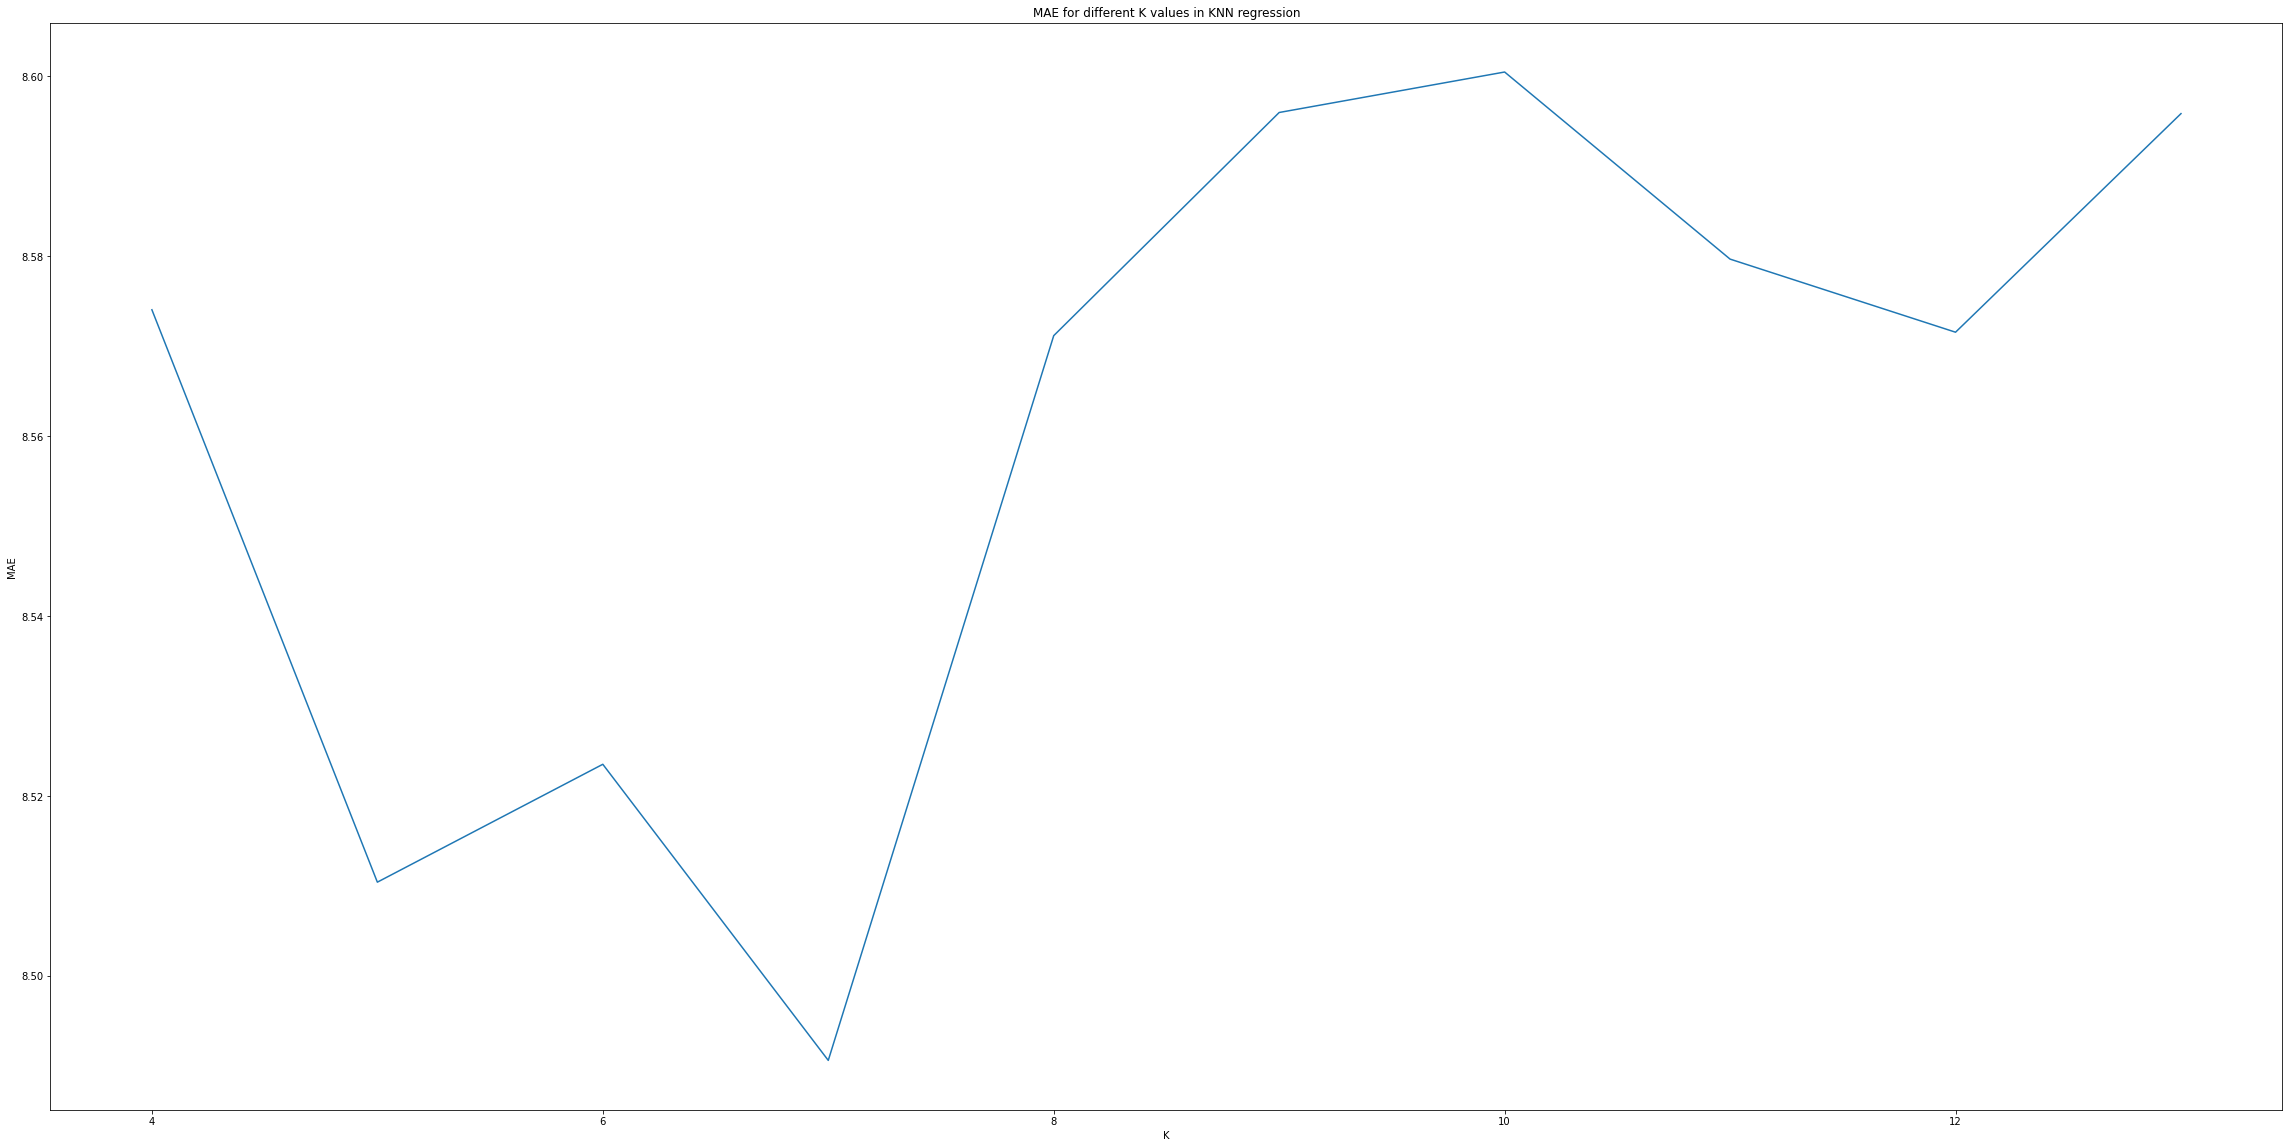

In [19]:
# execution time : 15 - 20 minutes
#test different knn
from sklearn.neighbors import KNeighborsRegressor
train_knn = scaled_train_lasso
test_knn = scaled_test_lasso
ks = []
mae = []
for i in range(4, 14): # tested for greater ranges before
    knn = KNeighborsRegressor(i)
    knn.fit(train_knn, y_train)
    pred = knn.predict(test_knn)
    ks.append(i)
    mae.append(mean_absolute_error(pred, y_test))

plt.figure(figsize=(40, 20))
plt.plot(ks, mae)
plt.xlabel('K')
plt.ylabel('MAE')
plt.title("MAE for different K values in KNN regression")



## Random Forest

In [20]:
#grid search random forest on nb estimators and max leaf nodes
from sklearn.model_selection import GridSearchCV
train_rf = new_train_data[['followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'followers_friends', 'hour', 'topic_2', 'topic_3', 'topic_4', 'topic_5']]
param_grid = {
    'n_estimators': [30, 50, 70, 90, 110],
    'max_leaf_nodes': [1000,1400,1800,2200]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)   
grid_search.fit(train_knn, y_train)
grid_search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


# Elasticity Net

In [ ]:
from sklearn.linear_model import ElasticNet
#plot mae for different alpha and l1_ratio
alpha = [0.1]
l1_ratio = np.linspace(0, 1, 10)
for a in alpha:
    mae = []
    for l in l1_ratio:
        reg = ElasticNet(alpha=a, l1_ratio=l)
        reg.fit(scaled_train_data, y_train)
        pred = reg.predict(scaled_test_data)
        mae.append(mean_absolute_error(pred, y_test))
    plt.figure(figsize=(20, 10))
    ax = plt.gca()
    ax.plot(l1_ratio, mae)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('MAE')
    plt.title("MAE for different alpha values in ElasticNet reggression")

## Part 4 : Top models

In [ ]:
# choose best features for each + top features
knn_best = KNeighborsRegressor(7)
lasso_best = Lasso(alpha=0.02)
rf_best = RandomForestRegressor(max_leaf_nodes=1400, n_estimators=90)

# take best features for knn
knn_scaler = StandardScaler()
knn_features_train = new_train_data[['followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'followers_friends', 'hour', 'topic_2', 'topic_3', 'topic_4', 'topic_5']]
knn_features_test = new_test_data[['followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'followers_friends', 'hour', 'topic_2', 'topic_3', 'topic_4', 'topic_5']]
scaler.fit(knn_features_train)
scaled_knn_train = scaler.transform(knn_features_train)
scaled_knn_test = scaler.transform(knn_features_test)

# take best features for lasso
lasso_scaler = StandardScaler()
lasso_train = new_train_data
lasso_test = new_test_data
lasso_scaler.fit(lasso_train)
scaled_lasso_train = lasso_scaler.transform(lasso_train)
scaled_lasso_test = lasso_scaler.transform(lasso_test)

# take best features for random forest
rf_train = new_train_data[['followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'followers_friends', 'hour', 'topic_2', 'topic_3', 'topic_4', 'topic_5']]
rf_test = new_test_data[['followers_count', 'friends_count', 'favorites_count', 'statuses_count', 'followers_friends', 'hour', 'topic_2', 'topic_3', 'topic_4', 'topic_5']]

#train the best models
knn_best.fit(scaled_knn_train, y_train)
lasso_best.fit(scaled_lasso_train, y_train)
rf_best.fit(rf_train, y_train)

#predict the best models
knn_pred = knn_best.predict(scaled_knn_test)
lasso_pred = lasso_best.predict(scaled_lasso_test)
rf_pred = rf_best.predict(rf_test)

#evaluate the best models
print("KNN MAE: ", mean_absolute_error(knn_pred, y_test))
print("Lasso MAE: ", mean_absolute_error(lasso_pred, y_test))
print("Random Forest MAE: ", mean_absolute_error(rf_pred, y_test))

RandomForestRegressor(max_features=0.93, max_leaf_nodes=2310, n_estimators=90,
                      n_jobs=-1)

<AxesSubplot:>

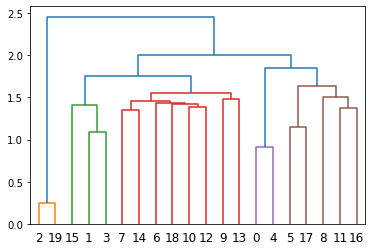

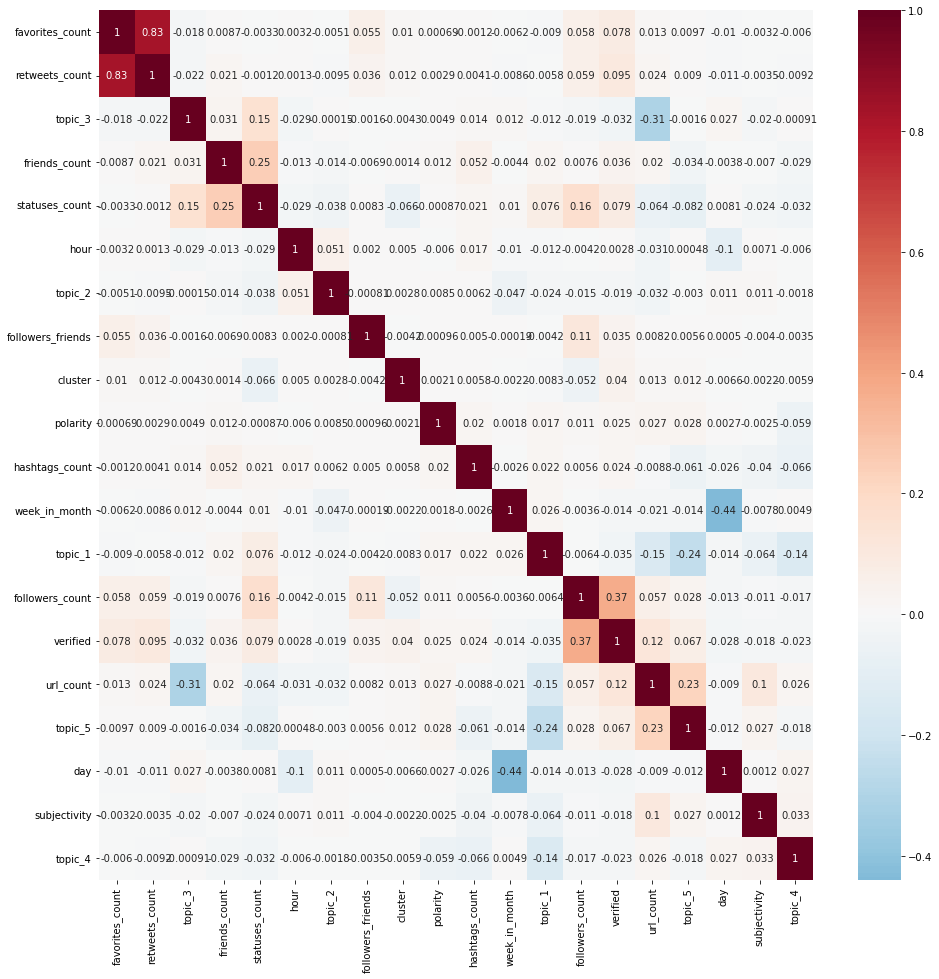

In [18]:
from scipy.cluster import hierarchy

%matplotlib inline

# plot correlation of features
#join new train data and y_train
df = pd.concat([new_train_data, y_train], axis=1)

order = np.array(hierarchy.dendrogram(hierarchy.ward(df.corr()), no_plot=False)['ivl'], dtype="int")
rearranged_cov = df.corr().iloc[order, order]
plt.figure(figsize=(16, 16))
sns.heatmap(rearranged_cov, annot=True, cmap="RdBu_r", center=0)